# 1. 전체 딥러닝 플로우 구현 해보기

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt 
%matplotlib inline

#### 데이터 Load 와 전처리

In [2]:
import torch
from torchvision import datasets, transforms

In [3]:
batch_size=32

In [4]:
# 데이터 로드(로컬에 없으면 다운로드)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("dataset/", download=True, train=True,
                   transform=transforms.Compose(
                       [
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0.5,), std=(0.5,))
                       ]
                   )), 
    batch_size=batch_size,
    shuffle=True
)

100%|██████████| 9912422/9912422 [00:01<00:00, 5194056.53it/s]


Extracting dataset/MNIST\raw\train-images-idx3-ubyte.gz to dataset/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 2760927.49it/s]


Extracting dataset/MNIST\raw\train-labels-idx1-ubyte.gz to dataset/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1750079.69it/s]


Extracting dataset/MNIST\raw\t10k-images-idx3-ubyte.gz to dataset/MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4340516.92it/s]

Extracting dataset/MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset/MNIST\raw



In [45]:
# test 데이터 로드
# train=False, shuffle=False
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("dataset/", download=True, train=False,
                   transform=transforms.Compose(
                       [
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0.5,), std=(0.5,))
                       ]
                   )), 
    batch_size=batch_size,
    shuffle=False
)

#### 데이터 확인

PyTorch에서는 TF와 이미지를 표현하는데 있어서 차이점이 있음. 

- TF - (batch, height, width, channel)
- PyTorch - (batch, channel, height, width)

In [7]:
images, labels = next(iter(train_loader))

In [10]:
images.shape, images.dtype

(torch.Size([32, 1, 28, 28]), torch.float32)

In [16]:
img = torch.squeeze(images[0]).numpy()

In [15]:
label = labels[0].numpy()

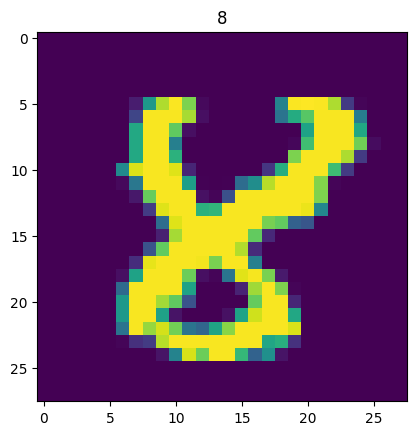

In [18]:
plt.title(label)
plt.imshow(img)
plt.show()

In [28]:
images, labels = next(iter(train_loader))

def load_img(idx):
    img = torch.squeeze(images[idx]).numpy()
    label = labels[idx].numpy()
    plt.title(label)
    plt.imshow(img)
    plt.show()

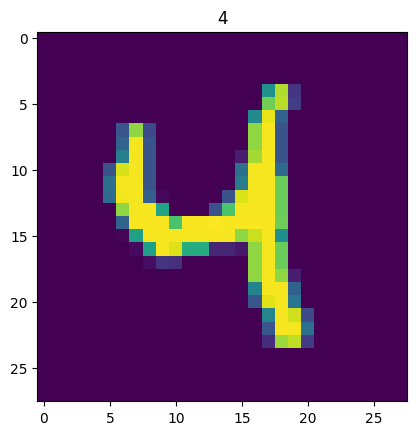

In [32]:
load_img(1)

----

### 모델 정의 

In [33]:
from torch import nn
import torch.nn.functional as F

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
model = Net().to(device)

In [37]:
print(model)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


### 학습 로직

PyTorch에서는 model을 Training 모드로 변경 후 Training 할 수 있다. 
- model.train()
- model.eval()

model 로직 과정
```
epoch
- batch
    - model
    - loss
    - grad
    - model update
```

In [41]:
import torch.optim as optim

In [42]:
opt = optim.SGD(model.parameters(), 0.03)

In [43]:
model.parameters()

<generator object Module.parameters at 0x000001F2A2D15B60>

In [50]:
for epoch in range(2):
    # 학습
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        loss = F.nll_loss(output, target)
        
        loss.backward()
        
        opt.step()
        
        print("batch {} loss : {}".format(batch_idx, loss.item()))
    
    # 평가    
    model.eval()
    
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target).item()
            
    test_loss /= (len(test_loader.dataset) // 32)
    
    print("Epoch {} test_loss : {}".format(epoch, test_loss))

batch 0 loss : 4.222564220428467
batch 1 loss : 4.7719197273254395
batch 2 loss : 4.808690071105957
batch 3 loss : 5.176224708557129
batch 4 loss : 3.7038352489471436
batch 5 loss : 5.794985771179199
batch 6 loss : 5.053822994232178
batch 7 loss : 4.820458889007568
batch 8 loss : 4.689880847930908
batch 9 loss : 5.643795490264893
batch 10 loss : 3.817101240158081
batch 11 loss : 4.290228843688965
batch 12 loss : 4.699160099029541
batch 13 loss : 4.419468402862549
batch 14 loss : 3.1167399883270264
batch 15 loss : 4.216551780700684
batch 16 loss : 3.376643180847168
batch 17 loss : 4.2250285148620605
batch 18 loss : 4.253504753112793
batch 19 loss : 3.3747880458831787
batch 20 loss : 3.9873030185699463
batch 21 loss : 4.28653621673584
batch 22 loss : 3.9396250247955322
batch 23 loss : 4.716596603393555
batch 24 loss : 5.045440196990967
batch 25 loss : 4.370390892028809
batch 26 loss : 4.276510715484619
batch 27 loss : 3.6782352924346924
batch 28 loss : 3.4561574459075928
batch 29 loss : 